In [1]:
import keras

Using TensorFlow backend.


In [4]:
from keras.datasets import boston_housing

In [13]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# Exploring the data

Dataset is limited in size.
Each sample contains 13 features that could impact the housing price.

In [6]:
train_data.shape

(404, 13)

In [7]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

To better preprocess the data, we sample each feature or column (axis=0) to zero mean, unit std.

In [10]:
train_data.mean(axis=0)

array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
       5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
       9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
       1.27408168e+01])

In [18]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
x_train = train_data - mean
x_train = x_train / std

Note that we save the mean and std, and use these values also on the testset. We will also use them when predicting on single samples

In [52]:
x_test = test_data - mean
x_test = x_test / std

In [22]:
print('mean', x_train.mean(axis=0), '\nstd', x_test.std(axis=0))

mean [-1.01541438e-16  1.09923072e-17  1.74337992e-15 -1.26686340e-16
 -5.25377321e-15  6.41414864e-15  2.98441140e-16  4.94653823e-16
  1.12671149e-17 -1.98136337e-16  2.36686358e-14  5.95679996e-15
  6.13920356e-16] 
std [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Building the model


In [26]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(13,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Since the dataset is limited in size, the validation set would most likely not well represent the data and can't thus be effectively used to tune hyperparameters. To solve this we use a technique called k-fold validation.

In [31]:
k = 4
validation_size = len(x_train) // k
results = []
epochs = 500
for i in range(k):
    x_val = x_train[i * validation_size: (i * validation_size) + validation_size]
    y_val = train_labels[i * validation_size: (i * validation_size) + validation_size]
    x_traink = np.concatenate([x_train[:i * validation_size], x_train[(i * validation_size) + validation_size:]])
    y_traink = np.concatenate([train_labels[:i * validation_size], train_labels[(i * validation_size) + validation_size:]])
    
    model = build_model()
    history = model.fit(x_traink, y_traink, batch_size=1, epochs=epochs, verbose=0, validation_data=(x_val, y_val))
    results.append(history.history['val_mean_absolute_error'])

res = [np.mean([x[i] for x in results]) for i in range(epochs)]

In [29]:
print(results)

[1.3066888496820683, 1.0733347722012612, 1.376800485570045, 1.1341971273076024]


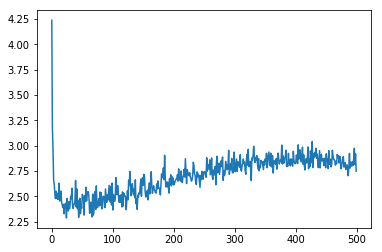

In [37]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), res)
plt.show()

In [42]:
def running_avg(data):
    smooth = []
    for i in range(len(data)):
        if i > 0:
            prev = smooth[-1]
            smooth.append(prev * 0.9 + data[i] * 0.1)
        else:
            smooth.append(data[i])
    return smooth
smoothed = running_avg(res)

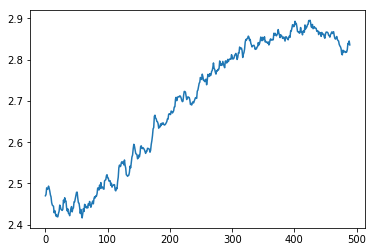

In [43]:
plt.plot(range(len(res[10:])), running_avg(res[10:]))
plt.show()

Training for 60 epochs seems best. Now that we verified that, we can train on entire dataset

In [58]:
model = build_model()
model.fit(x_train, train_labels, batch_size=16, epochs=80)

Epoch 1/80
404/404 [==============================] - 0s 535us/step - loss: 468.1990 - mean_absolute_error: 19.7411
Epoch 2/80
404/404 [==============================] - 0s 30us/step - loss: 278.5765 - mean_absolute_error: 14.6670
Epoch 3/80
404/404 [==============================] - 0s 31us/step - loss: 125.4825 - mean_absolute_error: 9.0881
Epoch 4/80
404/404 [==============================] - 0s 29us/step - loss: 58.2286 - mean_absolute_error: 5.7466
Epoch 5/80
404/404 [==============================] - 0s 31us/step - loss: 35.8743 - mean_absolute_error: 4.3538
Epoch 6/80
404/404 [==============================] - 0s 29us/step - loss: 27.1684 - mean_absolute_error: 3.7225
Epoch 7/80
404/404 [==============================] - 0s 30us/step - loss: 23.5096 - mean_absolute_error: 3.4287
Epoch 8/80
404/404 [==============================] - 0s 29us/step - loss: 20.6429 - mean_absolute_error: 3.1889
Epoch 9/80
404/404 [==============================] - 0s 29us/step - loss: 18.8728 - mean_

404/404 [==============================] - 0s 30us/step - loss: 6.0662 - mean_absolute_error: 1.7318
Epoch 74/80
404/404 [==============================] - 0s 30us/step - loss: 6.2968 - mean_absolute_error: 1.7556
Epoch 75/80
404/404 [==============================] - 0s 29us/step - loss: 6.1007 - mean_absolute_error: 1.7326
Epoch 76/80
404/404 [==============================] - 0s 30us/step - loss: 6.1843 - mean_absolute_error: 1.7183
Epoch 77/80
404/404 [==============================] - 0s 32us/step - loss: 6.0777 - mean_absolute_error: 1.7248
Epoch 78/80
404/404 [==============================] - 0s 30us/step - loss: 5.7794 - mean_absolute_error: 1.7071
Epoch 79/80
404/404 [==============================] - 0s 30us/step - loss: 6.2194 - mean_absolute_error: 1.7696
Epoch 80/80
404/404 [==============================] - 0s 31us/step - loss: 6.0395 - mean_absolute_error: 1.7201


Final val_mean_absolut_error is 2.1164, since labels of 1 = 1000 dollar, offset to validation is 2116 dollar

In [59]:
model.evaluate(x_test, test_labels)

102/102 [==============================] - 0s 789us/step


[20.386094336416207, 2.9506431373895383]

2711 dollar away from the testset